# Spam Filter with Naive Bayes

In this project, I will use the Naive Bayes algorithm by building a spam filter for SMS messages.

To classify messages as spam or non-spam the computer:

1. Learns how humans classify messages.
2. Uses that human knowledge to estimate probabilities for new messages — probabilities for spam and non-spam.
3. Classifies a new message based on these probability values — if the probability for spam is greater, then it classifies the message as spam. Otherwise, it classifies it as non-spam (if the two probability values are equal, then we may need a human to classify the message).

So the first task is to "teach" the computer how to classify messages. To do that, I'll use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by humans.

For this project, our goal is to create a spam filter that classifies new messages with an accuracy greater than 80% — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).

The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection#). 

In [1]:
import pandas as pd
import numpy as np

sms_spam = pd.read_csv('./dataset/SMSSpamCollection', sep='\t', header=None, names=['Label','SMS'])

In [2]:
sms_spam.shape

(5572, 2)

In [3]:
sms_spam.head(3)

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [4]:
sms_spam.tail(3)

,Label,SMS
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


In [5]:
sms_spam['Label'].value_counts(normalize=True)*100

ham     86.593683
spam    13.406317
Name: Label, dtype: float64

87% of the messages are 'ham' (which means non-spam) and the remaining 13% are spam.

## Training and Test Set

To test the spam filter, the dataset will be split into two categories:

* A **training set** (80% of the dataset), which we'll use to "train" the computer how to classify messages.
* A **test set** (20% of the dataset), which we'll use to test how good the spam filter is with classifying new messages.

The dataset has 5,572 messages, which means that:
* The training set will have 4,458 messages (about 80% of the dataset).
* The test set will have 1,114 messages (about 20% of the dataset).

To create a training and a test set, the entire dataset will be randmized to ensure that spam and ham messages are spread properly throughout the dataset.

In [6]:
# Randomizing the dataset
data_randomized = sms_spam.sample(frac=1, random_state=1)

# Calculate index for splits
training_test_index = round(len(data_randomized)*0.8)

# Training/Test split
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


We'll now analyze the percentage of spam and ham messages in the training and test sets. We expect the percentages to be close to what we have in the full dataset, where about 87% of the messages are ham, and the remaining 13% are spam.


In [7]:
training_set['Label'].value_counts(normalize=True)

ham     0.86541
spam    0.13459
Name: Label, dtype: float64

In [8]:
test_set['Label'].value_counts(normalize=True)


ham     0.868043
spam    0.131957
Name: Label, dtype: float64

The results look good! We'll now move on to cleaning the dataset.

## Data Cleaning

To calculate any probabilities, data cleaning needs to be performed to bring the data in a format that will allow us to extract easily all the information we need.

The end goal of the data cleaning process is to bring our training set to this format:

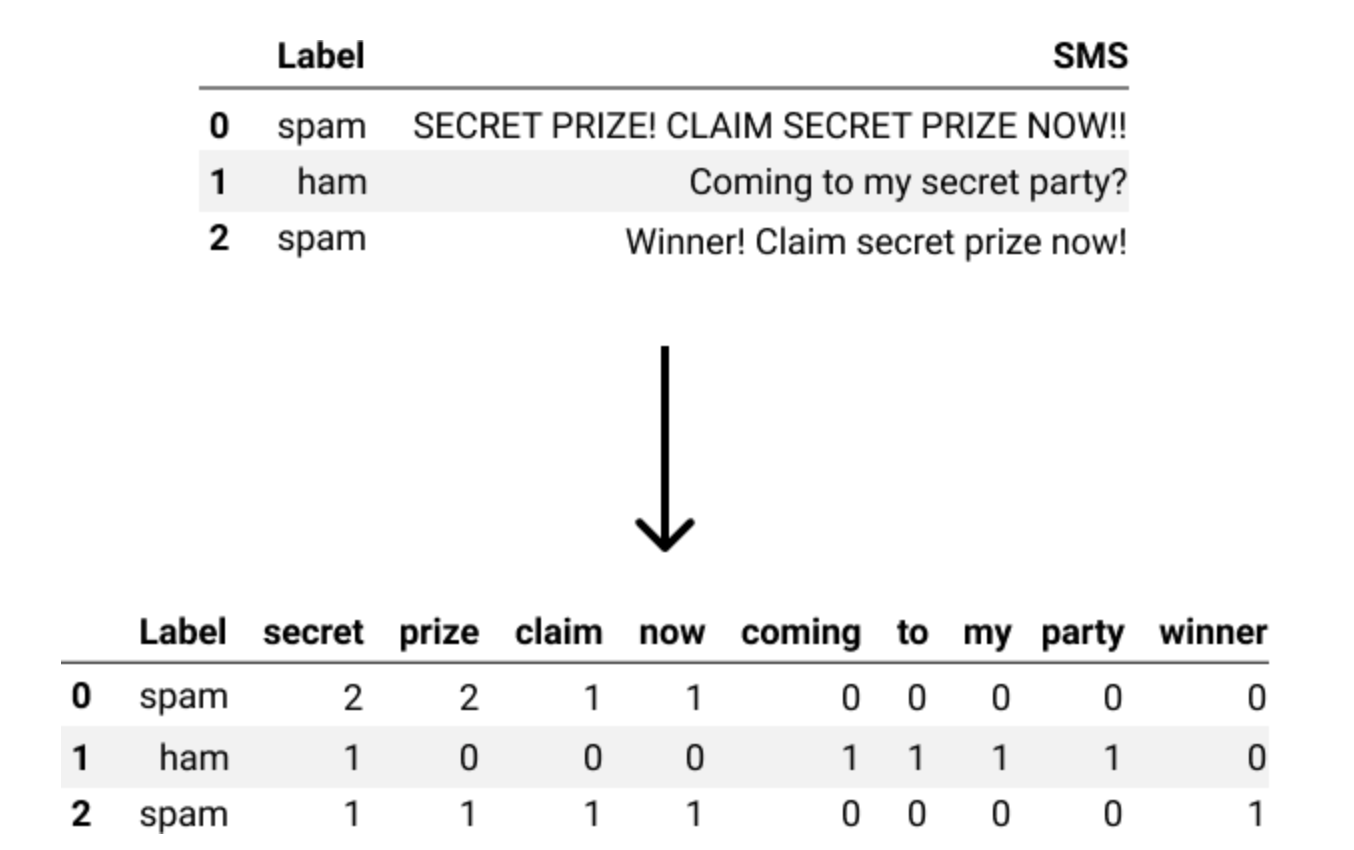

### Letter Case and Punctuation

First, need to remove punctuation and bring all the words to lower case. 

In [9]:
# Before cleaning
training_set.head()

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [10]:
# After cleaning
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ').str.lower()

training_set.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


## Creating the Vocabulary

With the exception of the "Label" column, every other column in the transformed table above represents a unique word in our vocabulary (more specifically, each column shows the frequency of that unique word for any given message). 

Create a list with all of the unique words that occur in the messages of our training set.

In [11]:
# Transforming each SMS into a list
training_set['SMS'] = training_set['SMS'].str.split()

vocabulary = []
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)

# turning list into set using set() function to remove duplicates
# then back into a list
vocabulary = list(set(vocabulary))

len(vocabulary)

7783

Looks like there are 7,783 unique words in all the messages of our training set. 

## The Final Training Set

Now going to use the vocabulary we just created to make the data transformation we want.

In [12]:
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [13]:
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,09066612661,stuck,nichols,dunno,yowifes,svc,franyxxxxx,theory,sleepin,2003,...,library,tea,contacts,lots,delivery,kavalan,scrappy,poop,rowdy,clubsaisai
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
training_set_clean = pd.concat([training_set, word_counts], axis=1)

training_set_clean.head()

,Label,SMS,09066612661,stuck,nichols,dunno,yowifes,svc,franyxxxxx,theory,...,library,tea,contacts,lots,delivery,kavalan,scrappy,poop,rowdy,clubsaisai
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculating Constants First




We're now done with cleaning the training set, and we can begin creating the spam filter. The Naive Bayes algorithm will need to answer these two probability questions to be able to classify new messages:
$$
P(Spam | w_1,w_2, ..., w_n) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_i|Spam)
$$$$
P(Ham | w_1,w_2, ..., w_n) \propto P(Ham) \cdot \prod_{i=1}^{n}P(w_i|Ham)
$$
Also, to calculate P(wi|Spam) and P(wi|Ham) inside the formulas above, we'll need to use these equations:
$$
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
$$$$
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
$$

Some of the terms in the four equations above will have the same value for every new message. We can calculate the value of these terms once and avoid doing the computations again when a new messages comes in. Below, we'll use our training set to calculate:
* P(Spam) and P(Ham)
* NSpam, NHam, NVocabulary

We'll also use Laplace smoothing and set $\alpha = 1$.

In [21]:
#Isolate Spam and Ham messages first
spam_messages = training_set_clean[training_set_clean['Label'] == 'spam']
ham_messages = training_set_clean[training_set_clean['Label'] == 'ham']

#P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(training_set_clean)
p_ham = len(ham_messages) / len(training_set_clean)

#N_Spam
n_spam_per_message = spam_messages['SMS'].apply(len)
n_spam = n_spam_per_message.sum()

#N_Ham
n_ham_per_message = ham_messages['SMS'].apply(len)
n_ham = n_ham_per_message.sum()

#N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

## Calculating Parameters


Now that we have the constant terms calculated above, we can move on with calculating the parameters $P(w_i|Spam)$ and $P(w_i|Ham)$. Each parameter will thus be a conditional probability value associated with each word in the vocabulary.

The parameters are calculated using the formulas:

$$
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
$$$$
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
$$

In [24]:
# Initiate parameters
parameters_spam = {unique_word: 0 for unique_word in vocabulary}
parameters_ham = {unique_word: 0 for unique_word in vocabulary}

# spam_word_count_per_sms = {}
# ham_word_count_per_sms = {}

# for word in vocabulary:
#     spam_word_count_per_sms[word] = 0
#     ham_word_count_per_sms[word] = 0

# Calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum()
    n_word_given_ham = ham_messages[word].sum()
    
    p_word_given_spam = (n_word_given_spam + alpha) / ((n_spam + alpha)*n_vocabulary)
    p_word_given_ham = (n_word_given_ham + alpha) / ((n_ham + alpha)*n_vocabulary)
    
    parameters_spam[word] = p_word_given_spam
    parameters_ham[word] = p_word_given_ham

## Classifying A New Message

In [28]:
# Classifying the message

import re

def classify(message):
    '''
    message: a string
    '''
    
    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [29]:
# Testing the classify function
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 5.32218937227696e-59
P(Ham|message): 5.821370428319695e-62
Label: Spam


In [30]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 2.5485202709195435e-51
P(Ham|message): 5.2028823344528615e-48
Label: Ham


## Measuring the Spam Filter's Accuracy

The two results above look promising, but let's see how well the filter does on our test set, which has 1,114 messages.

We'll start by writing a function that returns classification labels instead of printing them.

In [34]:
def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]

        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'
    
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [41]:
correct = 0
total = len(test_set)

for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1

accuracy = correct/total

print('Correct:', correct)
print('Incorrect:', total-correct)
print('Accurarcy:', correct/total)

Correct: 1078
Incorrect: 36
Accurarcy: 0.9676840215439856



The accuracy is close to 97%, which is really good. Our spam filter looked at 1,114 messages that it hasn't seen in training, and classified 1,078 correctly.

## Conclusion

In this project, we managed to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. The filter had an accuracy of 97% on the test set we used, which is a pretty good result. Our initial goal was an accuracy of over 80%, and we managed to do way better than that.
